# Drought Event Network

a. stein 7.28.2022

Okay. So following `explore/drought_tracking.ipynb` I did `quality_control/tset_drought_event_plot.ipynb` and found that while blob identifying and connecting over time works ... the id system is a nightmare and not very smooth to use, especially as I realized during testing that I needed one extra set of parenthesis around a split to make the id's unique. This makes sorting them a further pain and there isn't a great way to trace history despite the id being unique (writing something to then process sorting is really annoying). So, let's try making a nodal network to keep track of it instead in combination with networkx.

In [119]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

import skimage

from skimage.color import rgb2gray
from skimage.measure import regionprops_table

import networkx as nx

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's get our simpler test case up in here.

In [120]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

In [121]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
test_matrix = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

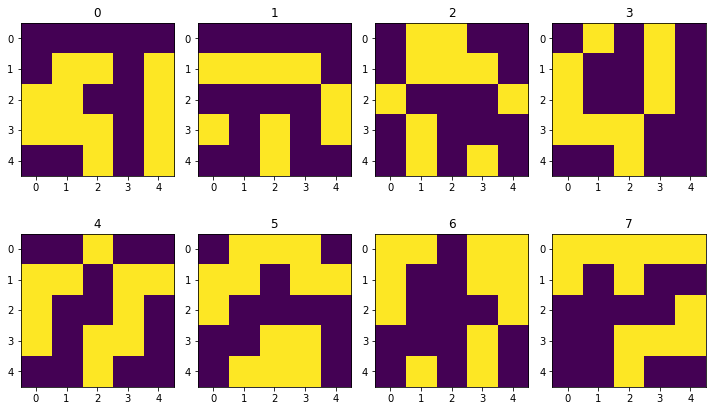

In [122]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

test_series = []
plot_matrix = test_matrix

for i, ax in enumerate(axs.ravel()):
    test_series.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

plt.tight_layout()

In [123]:
test_series = np.array(test_series)

In [124]:
class EventNode():

    def __init__(self, time, area, coords, id):
        self.time = time
        self.area = area
        self.coords = coords
        self.id = id
        self.future: List[EventNode] = list()

    def __str__(self):
        future_events = list()
        for future_EventNode in self.future:
            future_events.append(future_EventNode.id)
        return f'time: {self.time}, id: {self.id}, futures: {future_events}'

    def __iter__(self):
        yield self
        for node in self.future:
            yield node

    def __repr__(self):
        return f'time: {self.time}, id: {self.id}'

    def append_future(self, other):
        self.future.append(other)

    def check_connects(self, other, auto_connect=True):
        
        connection_found = False

        self_coord_set = set(tuple(coord) for coord in self.coords)
        other_coord_set = set(tuple(coord) for coord in other.coords)

        if len(self_coord_set.intersection(other_coord_set)) > 0:
            connection_found = True
            if auto_connect:
                self.append_future(other)
        
        return connection_found

    def get_future_thread(self, futures=[]):
        if not self in futures:
            futures.append(self)
       
        if len(self.future) > 0:
            for node in self.future:
                futures = node.get_future_thread(futures)
        
        return futures

Okay, I think above is a fairly good starting point for this class. I need to do the following:
- try constructing a string of `EventNode`'s and see if they match a test version
- figure out how to transition from nodes to timeseries
- figure out how to hold all the nodes for a timeseries together, given they can stop and end and may not all be connected

In [125]:
def create_EventNodes(vals:np.ndarray, time=0, id=0):
    df = wrangle.identify_drought_blob(vals)
    nodes = []
    for i in np.arange(len(df)):
        node = EventNode(
            time=time,
            area=df['area'].values[i],
            coords=df['coords'].values[i],
            id=id
        )
        nodes.append(node)
        id += 1

    # hopeful optimization
    df = None

    return nodes, id

In [126]:
test_nodes = []
id = 0
for i, data in enumerate(test_series):
    nodes, id = create_EventNodes(data, time=i, id=id)
    test_nodes.append(nodes)

In [127]:
test_nodes

[[time: 0, id: 0, time: 0, id: 1],
 [time: 1, id: 2, time: 1, id: 3, time: 1, id: 4],
 [time: 2, id: 5, time: 2, id: 6],
 [time: 3, id: 7],
 [time: 4, id: 8],
 [time: 5, id: 9, time: 5, id: 10],
 [time: 6, id: 11, time: 6, id: 12, time: 6, id: 13],
 [time: 7, id: 14, time: 7, id: 15]]

In [128]:
print(test_nodes[0][0])

time: 0, id: 0, futures: []


Yay, nothing blew up.

In [129]:
for i in np.arange(len(test_nodes)-1):
    for node in test_nodes[i]:
        for potential_future in test_nodes[i+1]:
            node.check_connects(potential_future)

In [130]:
print(test_nodes[0][0])

time: 0, id: 0, futures: [2, 3, 4]


Does the iteration work?

In [131]:
for node in test_nodes[0][0]:
    print(node)

time: 0, id: 0, futures: [2, 3, 4]
time: 1, id: 2, futures: [5]
time: 1, id: 3, futures: []
time: 1, id: 4, futures: []


Nice.

That's looking promising knowing one of them does do a 3-way split. Let's get the history codes in there

I'mma be needing to make an overarching class to contain all the events and maintain an encoding scheme.

In [132]:
class DroughtNetwork:

    def __init__(self, data):
        self.data = data
        self.origins: List[EventNode] = list()
        self.nodes: List[EventNode] = list()

        # go through and setup network
        last_nodes = []
        id = 0
        for i in np.arange(data.shape[0]):
            nodes_i, id = create_EventNodes(data[i,:,:], time=i, id=id)
            # see if we currently found some droughts
            if len(nodes_i) > 0:
                # and if last time step there were droughts
                # that this might connect to;
                # also make sure to keep the list of all nodes
                # going strong
                self.nodes.extend(nodes_i)
                if len(last_nodes) > 0:
                    for node in nodes_i:
                        # loop through the last nodes 
                        # to see if there is a connection
                        connection_found = False
                        for l, last_node in enumerate(last_nodes):
                            check = last_node.check_connects(node)
                            if check:                
                                connection_found = True
                        if not connection_found:
                            # if we couldn't find a connection
                            # then I'm considering it a new
                            # event for now
                            self.origins.append(node)
                else:
                    self.origins.extend(nodes_i)
                # need to preserve that we just had droughts
                # for the next time step
                last_nodes = nodes_i
            else:
                # if nothing was found, clear the holding list
                last_nodes = []

            # lastly, let's setup and adjacency matrix
            # the id will have been the last id plus 1,
            # which is great to set array dimensions
            self.adj_mat = np.zeros((id, id))
            for node in self.nodes:
                i_id = node.id
                for future in node.future:
                    j_id = future.id
                    self.adj_mat[i_id, j_id] = 1
        
    def find_node_by_id(self, id)  :
        for node in self.nodes:
            if node.id == id:
                return node
        
        raise Exception(f'id: {id} not in network')

    #def get_future_thread(self, node, futures=[]):
    #    if not node in futures:
    #        futures.append(node)
    #    
    #    for future_node in node.future:
    #        futures = self.get_future_thread(future_node, futures)
    #
    #    return futures
            
    def get_chronological_future_thread(self, id):
        node = self.find_node_by_id(id)
        nodes_to_sort = node.get_future_thread().copy()
        sorted_nodes = [nodes_to_sort[0]]
 
        if len(nodes_to_sort) > 1:
            for node in nodes_to_sort[1:]:
                if node.time >= sorted_nodes[-1].time:
                    sorted_nodes.append(node)
                else:
                    i = 0
                    while i <= len(sorted_nodes) and node.time > sorted_nodes[i].time:
                        i += 1
                    sorted_nodes.insert(i, node)

        # toss a little check in here
        if len(nodes_to_sort) != len(sorted_nodes):
            raise Exception('Something went wrong during sorting, check code.')

        return sorted_nodes

    def time_slice(start_time, end_time, id=None):
        # needs testing
        if id:
            # an option to combine the features of the two
            # functions
            nodes = self.get_chronological_future_thread(id)
        else:
            nodes = self.nodes
        
        time_sliced = []
        for node in nodes:
            t = node.time
            if t >= start_time and t <= end_time:
                time_sliced.append(node)
        
        return time_sliced

    def get_nx_network(self, id=None):

        topog = nx.from_numpy_array(self.adj_mat)

        if id is None:
            plot_nodes = self.nodes
        else:
            plot_nodes = self.get_chronological_future_thread(id)

        plot_ids = [node.id for node in plot_nodes]
        print(plot_ids)
        
        if plot_nodes != self.nodes:
            for node in self.nodes:
                if node.id not in plot_ids:
                    print(node.id)
                    topog.remove_node(node.id)
        
        pos = nx.drawing.nx_agraph.graphviz_layout(topog, prog= 'dot')

        return topog, pos

    

    

In [133]:
drought_network = DroughtNetwork(test_series)
drought_network

In [134]:
drought_network.origins

[time: 0, id: 0, time: 0, id: 1, time: 2, id: 6]

In [135]:
drought_network.nodes

[time: 0, id: 0,
 time: 0, id: 1,
 time: 1, id: 2,
 time: 1, id: 3,
 time: 1, id: 4,
 time: 2, id: 5,
 time: 2, id: 6,
 time: 3, id: 7,
 time: 4, id: 8,
 time: 5, id: 9,
 time: 5, id: 10,
 time: 6, id: 11,
 time: 6, id: 12,
 time: 6, id: 13,
 time: 7, id: 14,
 time: 7, id: 15]

In [136]:
drought_network.origins[0].id

0

In [137]:
for node in drought_network.nodes:
    print(node)

time: 0, id: 0, futures: [2, 3, 4]
time: 0, id: 1, futures: [2]
time: 1, id: 2, futures: [5]
time: 1, id: 3, futures: []
time: 1, id: 4, futures: []
time: 2, id: 5, futures: [7]
time: 2, id: 6, futures: []
time: 3, id: 7, futures: [8]
time: 4, id: 8, futures: [9, 10]
time: 5, id: 9, futures: [11, 12]
time: 5, id: 10, futures: [12, 13]
time: 6, id: 11, futures: [14]
time: 6, id: 12, futures: [14, 15]
time: 6, id: 13, futures: []
time: 7, id: 14, futures: []
time: 7, id: 15, futures: []


That's looking good, what about codes?

Splits should be easy enough to identify ... that'll just be multiple futures. Merges however, will need to see if the same node exists at the same time step in multiple futures I think ...

In [138]:
origins = drought_network.origins

Going to test equivalency ...

In [139]:
origins[0] == origins[0]

True

In [140]:
origins[0] == origins[1]

False

In [141]:
origins[0].get_future_thread()

[time: 0, id: 0,
 time: 1, id: 2,
 time: 2, id: 5,
 time: 3, id: 7,
 time: 4, id: 8,
 time: 5, id: 9,
 time: 6, id: 11,
 time: 7, id: 14,
 time: 6, id: 12,
 time: 7, id: 15,
 time: 5, id: 10,
 time: 6, id: 13,
 time: 1, id: 3,
 time: 1, id: 4]

I think I want to sort that by time ...

In [142]:
nodes_to_sort = origins[0].get_future_thread().copy()
sorted_nodes = [nodes_to_sort[0]]

for node in nodes_to_sort[1:]:
    if node.time >= sorted_nodes[-1].time:
        sorted_nodes.append(node)
    else:
        #print(node.time)
        i = 0
        while i <= len(sorted_nodes) and node.time > sorted_nodes[i].time:
            i += 1
        sorted_nodes.insert(i, node)

sorted_nodes

[time: 0, id: 0,
 time: 1, id: 4,
 time: 1, id: 3,
 time: 1, id: 2,
 time: 2, id: 5,
 time: 3, id: 7,
 time: 4, id: 8,
 time: 5, id: 10,
 time: 5, id: 9,
 time: 6, id: 13,
 time: 6, id: 12,
 time: 6, id: 11,
 time: 7, id: 14,
 time: 7, id: 15]

In [143]:
node_5 = drought_network.find_node_by_id(5)
node_5

time: 2, id: 5

In [144]:
print(node_5)

time: 2, id: 5, futures: [7]


In [145]:
node_5.get_future_thread()

[time: 0, id: 0,
 time: 1, id: 2,
 time: 2, id: 5,
 time: 3, id: 7,
 time: 4, id: 8,
 time: 5, id: 9,
 time: 6, id: 11,
 time: 7, id: 14,
 time: 6, id: 12,
 time: 7, id: 15,
 time: 5, id: 10,
 time: 6, id: 13,
 time: 1, id: 3,
 time: 1, id: 4]

In [146]:
drought_network.get_chronological_future_thread(5)

[time: 0, id: 0,
 time: 1, id: 4,
 time: 1, id: 3,
 time: 1, id: 2,
 time: 2, id: 5,
 time: 3, id: 7,
 time: 4, id: 8,
 time: 5, id: 10,
 time: 5, id: 9,
 time: 6, id: 13,
 time: 6, id: 12,
 time: 6, id: 11,
 time: 7, id: 14,
 time: 7, id: 15]

Woot, a sorting algorithm that was sooo much easier than before. Ah, but this destroys the higher up structures ... frick. At least that's maybe useful for plotting? idk. might be useful post codes

Going to add the above to the `DroughtNetwork` class

I'm wondering ... do I need a unique numbering scheme if they're connected in a network? I can just count them ... cause that sorting algorithm let's me get the thread fine


Let's try making a networkx plot of this

In [147]:
import networkx as nx

Following what I've done before, I can make an adjacency matrix and then compose a graph from that.

In [148]:
size = 16
adj_mat = np.zeros((size,size))
adj_mat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [149]:
for node in sorted_nodes:
    i_id = node.id
    for future in node.future:
        j_id = future.id
        print(i_id, j_id)
        adj_mat[i_id, j_id] = 1

adj_mat

0 2
0 3
0 4
2 5
5 7
7 8
8 9
8 10
10 12
10 13
9 11
9 12
12 14
12 15
11 14


array([[0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [150]:
topog = nx.from_numpy_matrix(adj_mat)
pos = nx.drawing.nx_agraph.graphviz_layout(topog, prog= 'dot')

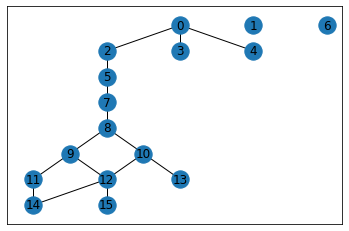

In [151]:
nx.draw_networkx(topog, pos)

That looks correct, it's just that I selected out 0 as the thread, so 1 doesn't get attached right. Let's see if I can remove that

In [152]:
topog.remove_node(1)
topog.remove_node(6)

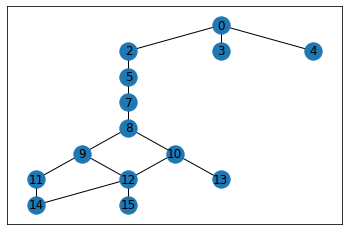

In [153]:
nx.draw_networkx(topog, pos)

Nice, so could literally loop through id and get rid of whatever is needed

There may be room for optimization by only constructing what is needed and then labeling accordingly, but this works for now.

Let's get these in that class as well. Then the last thing I want to do is be able to translate from the network to the timeseries ... a rather crucial part, but I'm not super worried given the time sorting works.

One thing that I'm thinking of is it could be helpful to give events that persist the same id's ... but this allows temporal visualization

In [154]:
for node in topog.nodes:
    print(node)

0
2
3
4
5
7
8
9
10
11
12
13
14
15


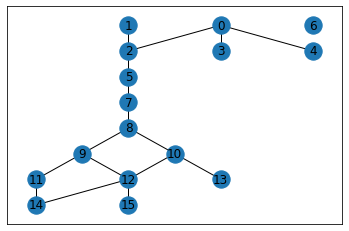

In [155]:
topog = nx.from_numpy_array(drought_network.adj_mat)
pos = nx.drawing.nx_agraph.graphviz_layout(topog, prog= 'dot')

nx.draw_networkx(topog, pos)

Nice.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


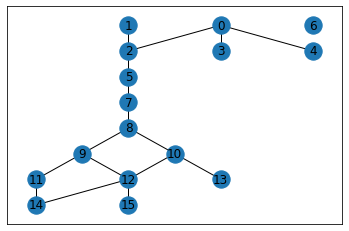

In [156]:
topog, pos = drought_network.get_nx_network()

nx.draw_networkx(topog, pos)

WOOT.

In [157]:
topog, pos = drought_network.get_nx_network(id=5)

[0, 4, 3, 2, 5, 7, 8, 10, 9, 13, 12, 11, 14, 15]
1
6


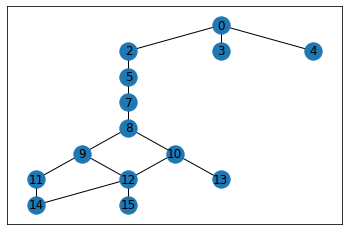

In [158]:
nx.draw_networkx(topog, pos)

Huh, for some reason this only works right if I toss an extra print in there ...

Okay, I have a bonkers theory, what if it works after throwing it into a python script.

In [159]:
import ndrought.drought_network as dnet

In [160]:
drought_net = dnet.DroughtNetwork(test_series)

In [161]:
node_5 = drought_net.find_node_by_id(5)
node_5

time: 2, id: 5

In [162]:
node_5.get_future_thread()

[time: 2, id: 5,
 time: 3, id: 7,
 time: 4, id: 8,
 time: 5, id: 9,
 time: 6, id: 11,
 time: 7, id: 14,
 time: 6, id: 12,
 time: 7, id: 15,
 time: 5, id: 10,
 time: 6, id: 13]

In [163]:
topog, pos = drought_net.get_nx_network(5)

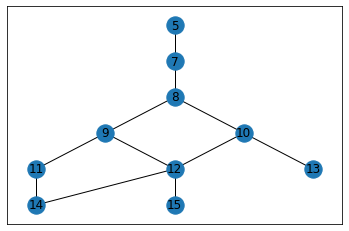

In [164]:
nx.draw_networkx(topog, pos)

Code is magic. I rest my case.

In [165]:
# testing the time_slice
drought_net.time_slice(2, 5)

[time: 2, id: 5,
 time: 2, id: 6,
 time: 3, id: 7,
 time: 4, id: 8,
 time: 5, id: 9,
 time: 5, id: 10]

Cool cool cool.

And now, to add in a function to convert from network to time series

In [166]:
time, vals = drought_net.thread_timeseries()

for t, v in zip(time, vals):
    print(t, v)

0 12.0
1 9.0
2 10.0
3 10.0
4 11.0
5 13.0
6 12.0
7 12.0


Double check this with something we know works...

In [167]:
for i, data in enumerate(test_series):
    print(i, data.sum())

0 12
1 9
2 10
3 10
4 11
5 13
6 12
7 12


Ayyy

Hm, I also know that an event the area of 1 pops up at time 2, can I get a timeseries showing that?

In [168]:
time, vals = drought_net.thread_timeseries(id=6)

for t, v in zip(time, vals):
    print(t, v)

2 10.0
3 10.0
4 11.0
5 13.0
6 12.0
7 12.0


Ah okay, it will clip to it, which makes sense. And isn't a detriment to plotting imo.

If I then start at time 3, I should get everything to be the same?

In [169]:
time, vals = drought_net.thread_timeseries(start_time=3, end_time=7)

for t, v in zip(time, vals):
    print(t, v)

3 10.0
4 11.0
5 13.0
6 12.0
7 12.0


Noticed `slice_time` needing start_time and end_time to be specified, so fixed that, let's test it:

In [170]:
time, vals = drought_net.thread_timeseries(start_time=3)
for t, v in zip(time, vals):
    print(t, v)

3 10.0
4 11.0
5 13.0
6 12.0
7 12.0


In [171]:
time, vals = drought_net.thread_timeseries(end_time=3)
for t, v in zip(time, vals):
    print(t, v)

0 12.0
1 9.0
2 10.0
3 10.0


Good good.

What about selecting out just the `1` thread?

In [172]:
time, vals = drought_net.thread_timeseries(id=1)
for t, v in zip(time, vals):
    print(t, v)

0 4.0
1 6.0
2 10.0
3 10.0
4 11.0
5 13.0
6 12.0
7 12.0


Yes, excellent.

Now I want to see if I can make that nice `fill_between` plot I made with the last version.

So I'll need it to be able to recognize when events are created, split, and merged.

I added in a group_id, let's see if it worked

In [173]:
drought_net.origins

[time: 0, id: 0, time: 0, id: 1, time: 2, id: 6]

In [174]:
for node in drought_net.nodes:
    print(node.time, node.id, node.group_id)

0 0 0
0 1 1
1 2 2
1 3 3
1 4 4
2 5 2
2 6 6
3 7 2
4 8 2
5 9 9
5 10 10
6 11 11
6 12 12
6 13 13
7 14 14
7 15 15


Woot. Love it. (yes that is accurate, did by hand)

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

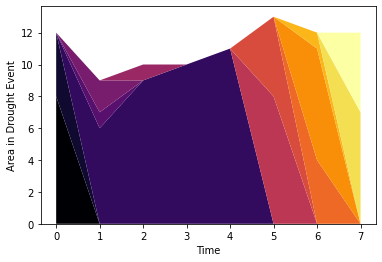

In [189]:
drought_net.stacked_events_plot(cmap=plt.cm.get_cmap('inferno'))

Love that.

Think it's time for some documentation then trying it out on the USDM

In [190]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

paired_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI.nc')

In [192]:
USDM_network = dnet.DroughtNetwork(paired_ds['USDM'].values)

  0%|          | 0/1148 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

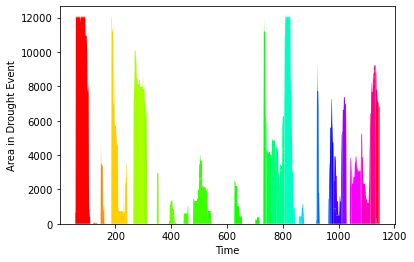

In [193]:
USDM_network.stacked_events_plot()

Ooo. That's looking right. Should probably change the CRS to an area projection instead of degree coordinates when actually doing analysis.

What does the network look like ...

In [195]:
topog, pos = USDM_network.get_nx_network()

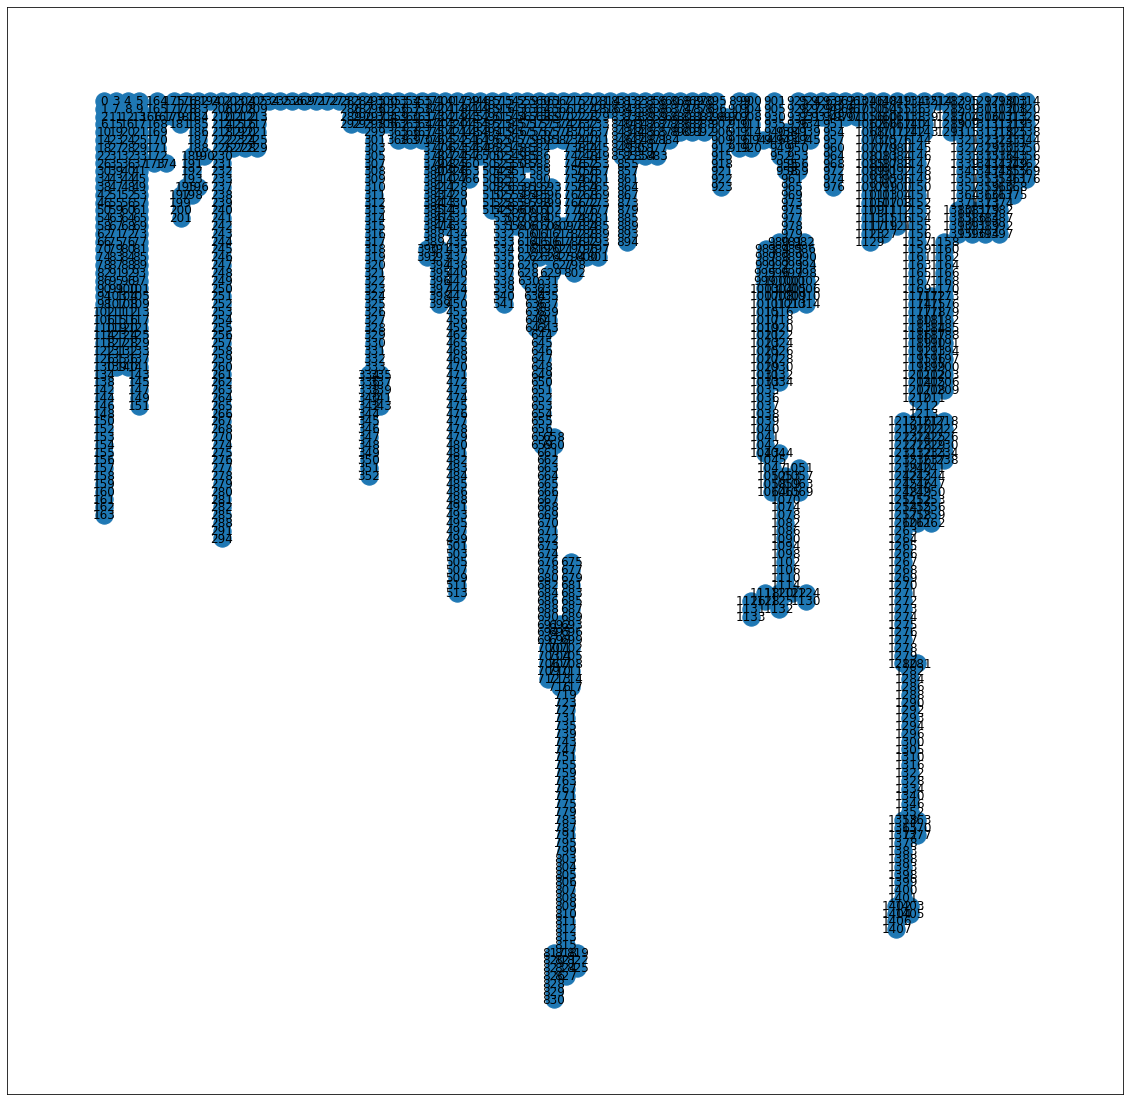

In [196]:
fig, ax = plt.subplots(figsize=(20,20))

nx.draw_networkx(topog, pos, ax=ax)

Okay, so that could use some cleaning up.

Can it run SPI though ...

In [197]:
SPI1y_network = dnet.DroughtNetwork(paired_ds['spi_1y'].values)

  0%|          | 0/1148 [00:00<?, ?it/s]

There's probably room for optimization ...

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

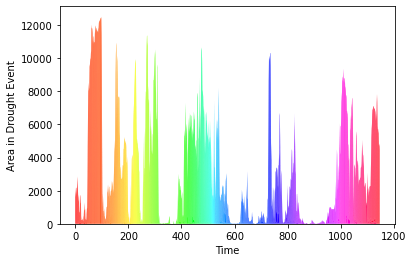

In [198]:
SPI1y_network.stacked_events_plot()

In [199]:
topog, pos = SPI1y_network.get_nx_network()

Yikes that's taking a while. Ended up being 4m 34.7s|

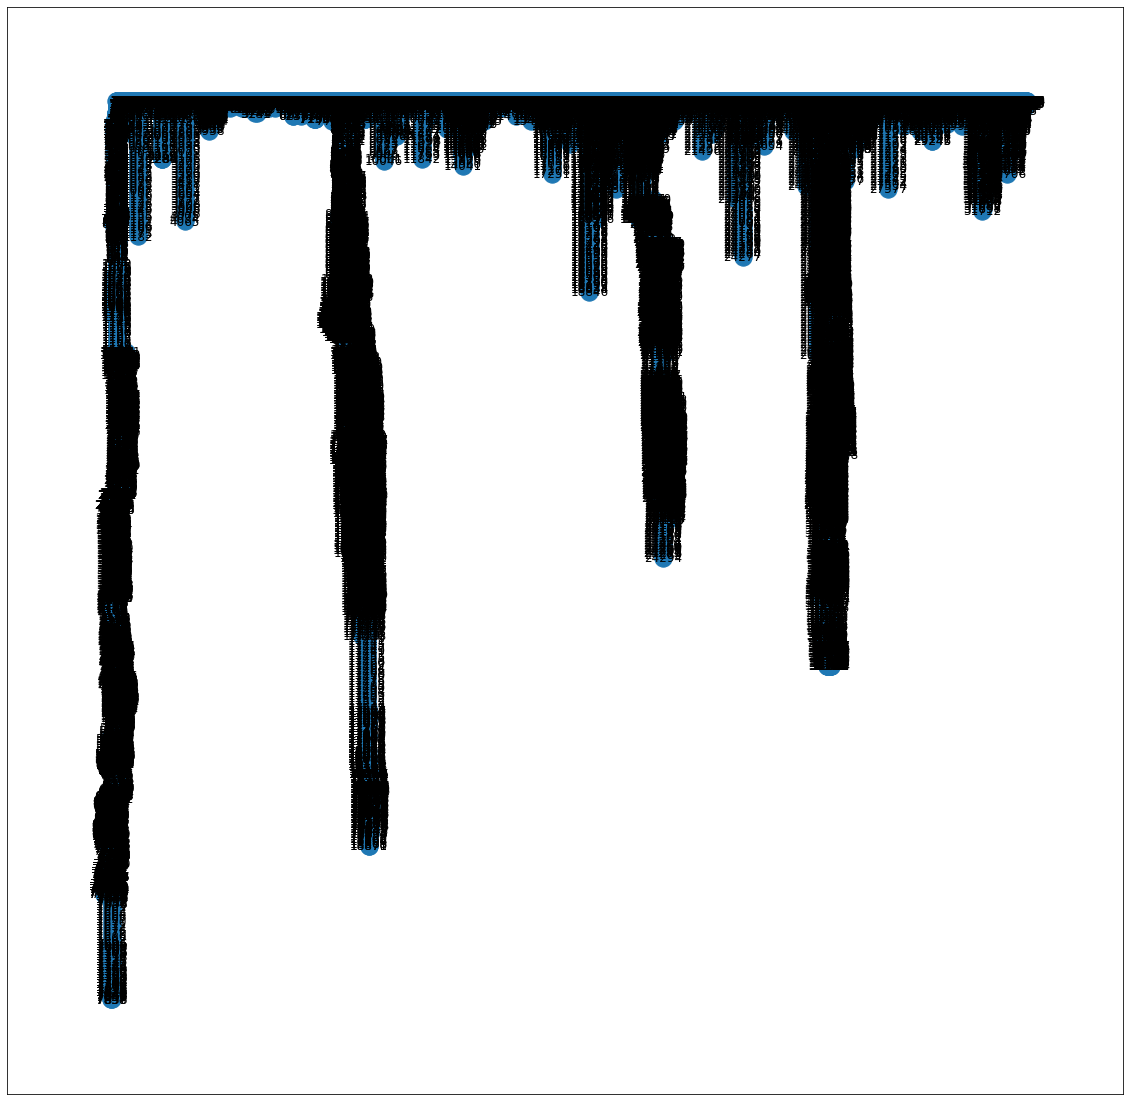

In [200]:
fig, ax = plt.subplots(figsize=(20,20))

nx.draw_networkx(topog, pos, ax=ax)

OMG. That looks like a printer had a heart attack.

Wish there was a way to easily write out and save these networks ... but I don't know how to do that yet.